In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from os import getcwd
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
work_dir = getcwd()
data_dir = join(work_dir, "data")
image_dir = join(work_dir, "images")

In [4]:
uber_base = {
    "B02512": "Unter",
    "B02598": "Hinter",
    "B02617": "Weiter",
    "B02682": "Schmecken",
    "B02764": "Danach-NY",
    "B02765": "Grun",
    "B02835": "Dreist",
    "B02836": "Drinnen"
}

In [5]:
# liste des fichiers de pickup
uber_pickup_files = {
    "April": "uber-raw-data-apr14.csv",
    "May": "uber-raw-data-may14.csv",
    "June": "uber-raw-data-jun14.csv",
    "July": "uber-raw-data-jul14.csv",
    "August": "uber-raw-data-aug14.csv",
    "September": "uber-raw-data-sep14.csv"
}

In [6]:
files = []
for f in uber_pickup_files.values():
    files.append(pd.read_csv(join(data_dir, f)))
uber = pd.concat(files, ignore_index=True)

In [7]:
uber.shape

(4534327, 4)

In [8]:
uber.tail()

,Date/Time,Lat,Lon,Base
4534322,9/30/2014 22:57:00,40.7668,-73.9845,B02764
4534323,9/30/2014 22:57:00,40.6911,-74.1773,B02764
4534324,9/30/2014 22:58:00,40.8519,-73.9319,B02764
4534325,9/30/2014 22:58:00,40.7081,-74.0066,B02764
4534326,9/30/2014 22:58:00,40.7140,-73.9496,B02764


In [9]:
columns = ["Lat", "Lon", "Weekday", "Hour"]

def preprocessing(df):
    
    X = df.copy()
    
    X["Date/Time"] = pd.to_datetime(X["Date/Time"], infer_datetime_format=True)
    X["Month"] = X["Date/Time"].dt.month
    X["Weekday"] = X["Date/Time"].dt.weekday
    X["Hour"] = X["Date/Time"].dt.hour
    X["Location"] = [[a, b] for a, b in zip(X["Lat"].values, X["Lon"].values)]
     
    return X

In [66]:
X = preprocessing(uber)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date/Time  datetime64[ns]
 1   Lat        float64       
 2   Lon        float64       
 3   Base       object        
 4   Month      int64         
 5   Weekday    int64         
 6   Hour       int64         
 7   Location   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 276.8+ MB


In [12]:
X.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,0,"[40.769, -73.9549]"
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,0,"[40.7267, -74.0345]"
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,0,"[40.7316, -73.9873]"
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,0,"[40.7588, -73.9776]"
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,0,"[40.7594, -73.9722]"


In [13]:
X["Lon"].nunique() / X.shape[0]

0.002525843416233545

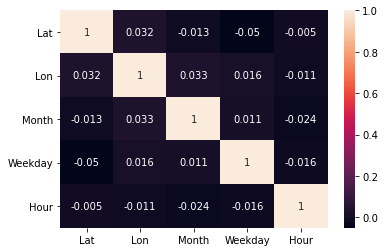

In [14]:
sns.heatmap(X.corr(), annot=True);

In [15]:
X[["Lat", "Lon"]].min(), X[["Lat", "Lon"]].max()

(Lat    39.6569
 Lon   -74.9290
 dtype: float64,
 Lat    42.1166
 Lon   -72.0666
 dtype: float64)

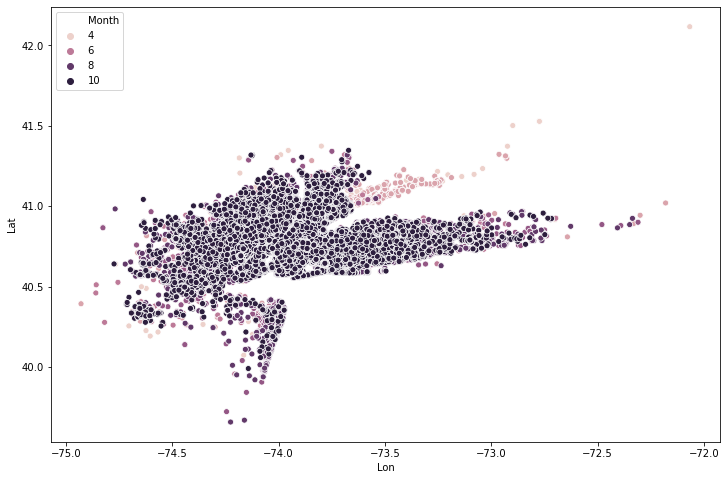

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=X, x="Lon", y="Lat", hue="Month", ax=ax);
#fig.savefig(join(image_dir, "coordinates_by_month.png"), transparent=False, dpi=80, bbox_inches="tight")

### On garde les variables continues

In [67]:
# on restreint le nombre d'individus à 100000
X_st = X[columns].values
np.random.shuffle(X_st)
X_100 = X_st[np.random.randint(0, X_st.shape[0], 100000)]

##### standardisation

In [68]:
sc_X = StandardScaler()
X_st = sc_X.fit_transform(X_st)
X_100_st = sc_X.transform(X_100)

### Recherche du nombre de cluster optimal

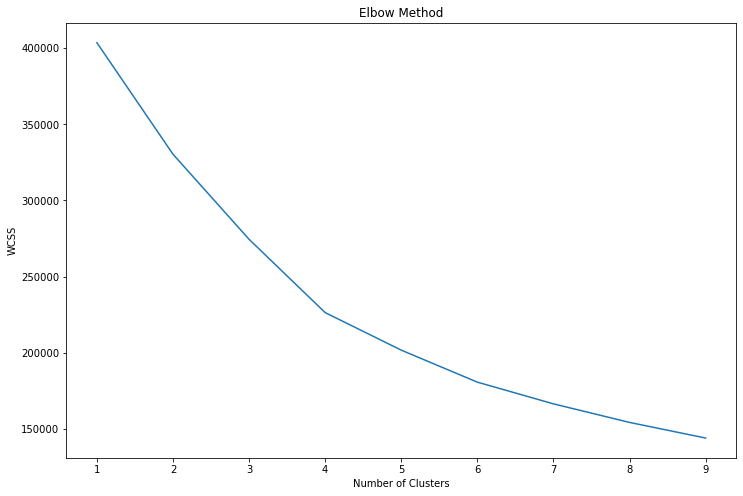

<IPython.core.display.Javascript object>

In [19]:
%%notify -m "Elbow terminé"

# créer une boucle pour stocker les inerties calculées pour chaque kmeans en itérant sur le nombre de cluster

n_clusters = 10

wcss = []
for i in range (1, n_clusters): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(X_100)
    wcss.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(range(1, n_clusters), wcss)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WCSS')

plt.show()
#fig.savefig(join(image_dir, "Elbow.png"), transparent=False, dpi=80, bbox_inches="tight")

### Un coude semble se dessiner à 4 clusters
Essai de confirmation avec la silouhette

For n_clusters = 3, the average silhouette_score is : 0.2638685763179483
For n_clusters = 4, the average silhouette_score is : 0.2599613265581691
For n_clusters = 5, the average silhouette_score is : 0.24836732900224945


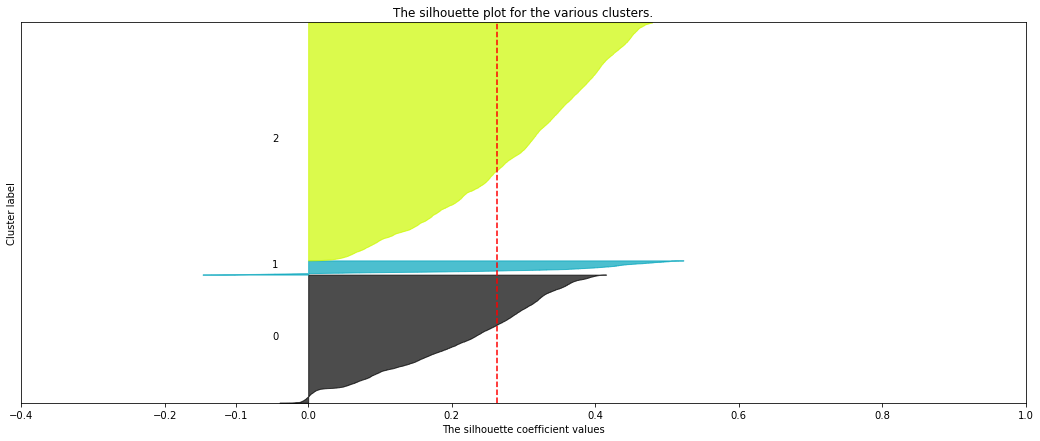

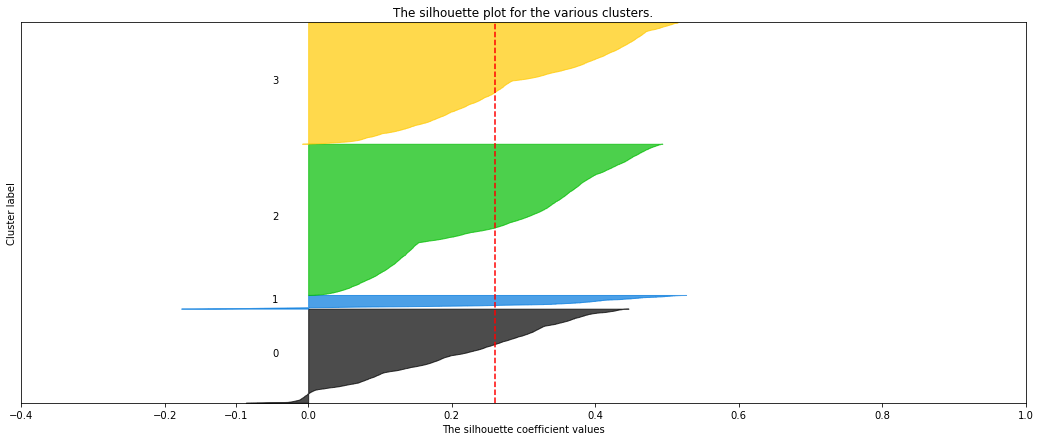

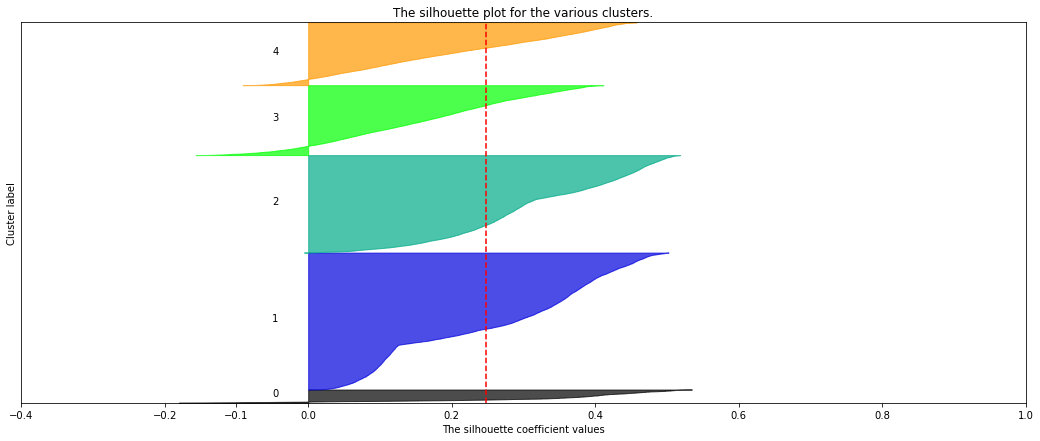

<IPython.core.display.Javascript object>

In [50]:
%%notify -m "Silhouette terminée"

range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    
    fig, ax = plt.subplots(figsize=(18, 7))
    
    # The silhouette coefficient can range from -1, 1
    
    ax.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_100) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, init = "k-means++", max_iter = 300, n_init = 10, random_state=42)
    cluster_labels = clusterer.fit_predict(X_100)

    silhouette_avg = silhouette_score(X_100, cluster_labels)
    print(f"For {n_clusters = }, the average silhouette_score is : {silhouette_avg}")
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_100, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

### On garde le nombre de 3 clusters

In [18]:
%%notify -m "3-means terminé"

kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=100, n_init=10, random_state=42)
kmeans.fit(X_st)
y_kmeans = kmeans.predict(X_st)

<IPython.core.display.Javascript object>

In [19]:
centroids = kmeans.cluster_centers_
centroids

array([[ 0.02862576, -0.13463896,  0.7234095 ,  0.00478465],
       [-1.79153896,  3.39132786,  0.06843471,  0.04926415],
       [ 0.12723107, -0.13035019, -0.99991492, -0.01115112]])

In [20]:
centroids = pd.DataFrame(sc_X.inverse_transform(centroids), columns=columns)
centroids

,Lat,Lon,Weekday,Hour
0,40.740404,-73.980730,4.325210,14.246821
1,40.667689,-73.778809,3.096497,14.511863
2,40.744344,-73.980484,1.092305,14.151863


In [21]:
X["3_means"] = y_kmeans

In [22]:
X.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location,3_means
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,0,"[40.769, -73.9549]",0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,0,"[40.7267, -74.0345]",0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,0,"[40.7316, -73.9873]",0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,0,"[40.7588, -73.9776]",0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,0,"[40.7594, -73.9722]",0


In [23]:
X_4 = X[X["Month"] == 4]

3-means clusters :
![alt tex](images/3-means_pickup_clusters.png)

In [24]:
quantile_list = [0, .25, .5, .75, 1.]

def quantile_labels(feature_quantiles):
    """
    return the list of the feature quantiles labels
    """
    return [f"{int(feature_quantiles.iloc[q])}-{int(feature_quantiles.iloc[q+1])}" for q in range(len(feature_quantiles) - 1)]

hour_quantiles = X["Hour"].quantile(quantile_list)
hour_bins_labels = quantile_labels(hour_quantiles)
X["Hour"] = pd.qcut(X["Hour"], q=quantile_list, labels=hour_bins_labels)

In [25]:
X.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location,3_means
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,0-10,"[40.769, -73.9549]",0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,0-10,"[40.7267, -74.0345]",0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,0-10,"[40.7316, -73.9873]",0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,0-10,"[40.7588, -73.9776]",0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,0-10,"[40.7594, -73.9722]",0


In [26]:
X_4_0 = X_4[X_4["3_means"] == 0]
X_4_1 = X_4[X_4["3_means"] == 1]
X_4_2 = X_4[X_4["3_means"] == 2]

1st cluster by hour
![alt text](images/1st_cluster_hour.png)

2nd cluster by hour
![alt text](images/2nd_cluster_hour.png)

3rd cluster by hour
![alt text](images/3rd_cluster_hour.png)

## DBSCAN
### Recherche du epsilon

In [69]:
nearest = NearestNeighbors(n_neighbors=2, n_jobs=-1)
neighbours = nearest.fit(X_100_st)

In [70]:
dist, ind = neighbours.kneighbors(X_100_st)

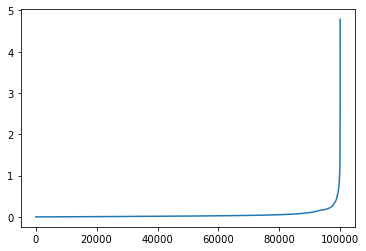

In [71]:
dist = np.sort(dist, axis=0)
dist = dist[:,1]
plt.plot(dist)

##### On retient epsilon = 0.5

In [131]:
%%notify -m "DBSCAN terminé"

dbscan = DBSCAN(eps=0.6, min_samples=40)
y_dbscan = dbscan.fit_predict(X_100_st)

<IPython.core.display.Javascript object>

In [132]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2], dtype=int64)

In [133]:
#X_100 = pd.DataFrame(X_100, columns=columns)
X_100["dbscan"] = y_dbscan

In [134]:
X_100.head()

,Lat,Lon,Weekday,Hour,dbscan
0,40.6646,-73.9286,2.0,8.0,0
1,40.8614,-73.9278,0.0,3.0,-1
2,40.7100,-73.9626,6.0,14.0,0
3,40.7053,-74.0088,3.0,17.0,0
4,40.7200,-74.0055,0.0,9.0,0


DBSCAN clusters
![alt text](images/dbscan_pickup_clusters.png)

DBSCAN cluster 1
![alt text](images/dbscan_pickup_clusters_1_hour.png)
DBSCAN cluster 2
![alt text](images/dbscan_pickup_clusters_2_hour.png)
DBSCAN cluster 3
![alt text](images/dbscan_pickup_clusters_3_hour.png)
DBSCAN cluster outliers
![alt text](images/dbscan_pickup_clusters_out_hour.png)